### Importation des bibliothèques

In [8]:
import os
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from skimage import color
from skimage import data, transform
from sklearn.datasets import fetch_lfw_people
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.transform import resize
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain     
        

<ipython-input-8-138b1c1d5fe0>:24: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())
/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("

0.9885503914410378

In [ ]:
faces = fetch_lfw_people()
positive_patches = faces.images


imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negatives_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

X_train = np.array([hog(img)
                    for img in chain(positive_patches,
                                     negatives_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

<ipython-input-5-ee60141ae238>:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


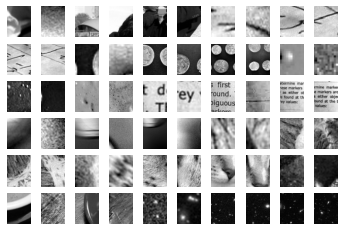

In [5]:
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

In [9]:
grid.best_params_

{'C': 1.0}

In [10]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC()

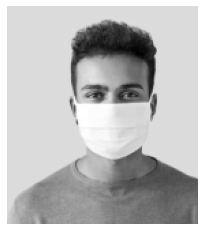

In [17]:
test_image = skimage.io.imread('img/testset/chir/mask-chir1.jpg')  
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [18]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [19]:
labels = model.predict(patches_hog)
labels.sum()

26.0

### Affichage des résultats

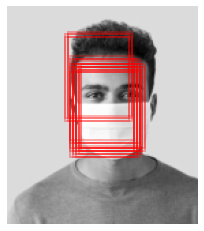

In [20]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))